In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import configparser
import sys
import os
import pandas as pd
import skimage
import requests
from pprint import pprint

sys.path.append(os.path.abspath('../Module'))
import preprocessing
import visualize

In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

In [3]:
data_dir = vg_json_export + 'vandeweijer2007/'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
if 'ColorNaming' in os.listdir(data_dir):
    data_dir += 'ColorNaming/'
else:
    # tar-Datei in Verzeichnis extrahieren
    import requests, tarfile, io
    url = 'http://lear.inrialpes.fr/people/vandeweijer/code/ColorNaming.tar'
    r = requests.get(url)
    b = io.BytesIO(r.content)
    tar = tarfile.TarFile(fileobj=b)
    tar.extractall(path=data_dir)
    data_dir += 'ColorNaming/'

# Reihenfolge von 'colors' aus Datei im2c.m
colors = 'black blue brown grey green orange pink purple red white yellow'.split()
# Spaltennamen für w2c-Datei
rgb_colors = 'r g b'.split()+colors

In [4]:
w2c = []
# w2c-Datei einlesen; Zeilen als Einträge in w2c-Liste
f = open(data_dir+'w2c.txt', 'r')
for line in f:
    line = line.replace(' \n', '')
    w2c.append(line.split())

# NumPy-Array aus w2c-Liste erstellen
w2c_arr = np.array(w2c).astype('float64')

In [5]:
w2c_arr[:50,0:3]

array([[  3.5,   3.5,   3.5],
       [ 11.5,   3.5,   3.5],
       [ 19.5,   3.5,   3.5],
       [ 27.5,   3.5,   3.5],
       [ 35.5,   3.5,   3.5],
       [ 43.5,   3.5,   3.5],
       [ 51.5,   3.5,   3.5],
       [ 59.5,   3.5,   3.5],
       [ 67.5,   3.5,   3.5],
       [ 75.5,   3.5,   3.5],
       [ 83.5,   3.5,   3.5],
       [ 91.5,   3.5,   3.5],
       [ 99.5,   3.5,   3.5],
       [107.5,   3.5,   3.5],
       [115.5,   3.5,   3.5],
       [123.5,   3.5,   3.5],
       [131.5,   3.5,   3.5],
       [139.5,   3.5,   3.5],
       [147.5,   3.5,   3.5],
       [155.5,   3.5,   3.5],
       [163.5,   3.5,   3.5],
       [171.5,   3.5,   3.5],
       [179.5,   3.5,   3.5],
       [187.5,   3.5,   3.5],
       [195.5,   3.5,   3.5],
       [203.5,   3.5,   3.5],
       [211.5,   3.5,   3.5],
       [219.5,   3.5,   3.5],
       [227.5,   3.5,   3.5],
       [235.5,   3.5,   3.5],
       [243.5,   3.5,   3.5],
       [251.5,   3.5,   3.5],
       [  3.5,  11.5,   3.5],
       [ 1

In [9]:
# DataFrame erstellen, Einträge aus w2c hinzufügen, Einträge in DataFrame als float64
w2c_df = pd.DataFrame(columns=rgb_colors)

for entry in w2c:
    w2c_df = w2c_df.append(pd.Series(entry, index=rgb_colors), ignore_index=True)
w2c_df= w2c_df.astype('float64', copy=False)

# Per idxmax: Wahrscheinlichste Farbe für RGB-Wert
w2c_df['color'] = w2c_df[colors].idxmax(axis=1)

w2c_df.head()

r    g    b     black      blue     brown      grey     green    orange  \
0   3.5  3.5  3.5  0.293958  0.020885  0.037604  0.071886  0.141474  0.064986   
1  11.5  3.5  3.5  0.330787  0.028917  0.050061  0.072332  0.123315  0.062952   
2  19.5  3.5  3.5  0.375413  0.028445  0.055683  0.072660  0.096563  0.067473   
3  27.5  3.5  3.5  0.298999  0.022142  0.111073  0.074210  0.062086  0.093956   
4  35.5  3.5  3.5  0.092343  0.017636  0.229077  0.064490  0.048865  0.128829   

       pink    purple       red     white    yellow  color  
0  0.058097  0.125870  0.059671  0.006976  0.118593  black  
1  0.056099  0.114169  0.058952  0.005640  0.096776  black  
2  0.054926  0.091975  0.071449  0.005915  0.079498  black  
3  0.060683  0.098694  0.111921  0.005485  0.060749  black  
4  0.070291  0.135458  0.177669  0.002874  0.032470  brown

In [19]:
def color_pixelwise(img, w2c, bb=False):
    # vgl. Datei im2c.m aus http://lear.inrialpes.fr/people/vandeweijer/code/ColorNaming.tar
    # Input: Bild-Pfad und w2c-Matrix (Mapping von RGB-Werten zu Farbnamen)
    
    # Bild als Array
    img = skimage.io.imread(img)
    
    # img-Array slicen, falls Bounding Box gegeben
    if bb:
        if type(bb) == list:
            bb ={
                'h' : bb[0],
                'w' : bb[1],
                'x' : bb[2],
                'y' : bb[3]
            }
        img = img[bb['y']:bb['y']+bb['h'], bb['x']:bb['x']+bb['w']]
    
    # Kanäle trennen
    RR=img[:,:,0]
    GG=img[:,:,1]
    BB=img[:,:,2]
    
    # Index-Array erstellen: Ein Index-Wert pro Pixel
    index_img = np.array(
        # R-Werte (32 Bins)
        np.floor(RR/8)+
        # G-Werte (32 Bins)
        32* np.floor(GG/8)+
        # B-Werte (32 Bins)
        32*32*np.floor(BB/8)
    )
    # Array für Wahrscheinlichkeitsverteilung über Farbklassen initialisieren
    clr_distribution = np.zeros(11)
    
    # Für jeden Index-Wert die jeweils assoziierte Wahrscheinlichkeitsverteilung zu clr_distribution addieren
    for pxl_index in index_img.ravel():
        clr_distribution = clr_distribution + w2c[int(pxl_index)][3:]
        
    # clr_distribution normalisieren
    clr_distribution = clr_distribution / len(index_img.ravel())
    
    return clr_distribution

In [10]:
chip_w2c_df = pd.read_csv(data_dir+"chip_w2c.csv", index_col=0)
chip_w2c_arr = chip_w2c_df.to_numpy()

blue 0.8669720000000198 

{('black', 0.006719000000000239),
 ('blue', 0.8669720000000198),
 ('brown', 0.0011389999999999714),
 ('green', 0.001504000000000035),
 ('grey', 0.00953299999999995),
 ('orange', 0.008181999999999837),
 ('pink', 0.0002720000000000003),
 ('purple', 0.05230000000000159),
 ('red', 0.029609000000000565),
 ('white', 0.007835000000000035),
 ('yellow', 0.015934999999999595)}


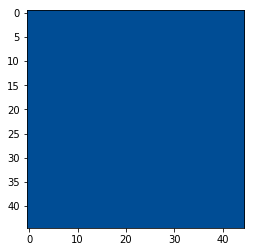

In [35]:
url = 'https://upload.wikimedia.org/wikipedia/commons/9/9c/Ceruleanblue.jpg'
plt.imshow(skimage.io.imread(url))

dist = color_pixelwise(url, w2c_arr)

color_dist = set(zip(colors,dist))
pred_color = dict(zip(dist,colors))[max(dist)]

print(pred_color, max(dist), '\n')
pprint(color_dist)

In [36]:
dist = color_pixelwise(url, chip_w2c_arr)

color_dist = set(zip(colors,dist))
pred_color = dict(zip(dist,colors))[max(dist)]

print(pred_color, max(dist), '\n')
pprint(color_dist)

blue 0.8132827882543684 

{('black', 1.0257790977732544e-15),
 ('blue', 0.8132827882543684),
 ('brown', 1.6036784960420427e-91),
 ('green', 0.18671721174560715),
 ('grey', 6.634252492538545e-25),
 ('orange', 4.8300627259247466e-253),
 ('pink', 1.0830918551292405e-77),
 ('purple', 1.1647048598810023e-20),
 ('red', 1.2088501001512243e-170),
 ('white', 0.0),
 ('yellow', 2.3712209681368856e-67)}


## Inhalt im2c.m (+Kommentare)